# Setting up test and benchmark functions

In [ ]:
"""
old_coordinator.py: updated coordinator for testing and benchmarking code debuggers
"""
import warnings
warnings.filterwarnings("ignore")
import json
import os
import sys
import importlib.util
import torch
import time
from datetime import datetime
from tqdm import tqdm
from typing import Dict, List, Any, Optional, Tuple, Union
from google.colab import drive
drive.mount('/content/drive')

!pip install langchain openai
!pip install --upgrade langchain langchain-community openai

# use LLM-based code parser if available
try:
    from langchain_community.chat_models import ChatOpenAI
    from langchain_core.messages import HumanMessage
    from google.colab import userdata
    import openai
    # Set environment variables
    openai.api_key = userdata.get('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY'] = openai.api_key
    HAVE_OPENAI = True
except Exception as e:
    print(f"Warning: LangChain/OpenAI not available: {e}")
    HAVE_OPENAI = False

# Set environment variables for PyTorch
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

class DebuggerCoordinator:
    """
    Central coordinator for loading, testing, and benchmarking code debuggers.
    Manages multiple debugger models to do testing.
    """

    def __init__(self, base_path: str = None):
        """
        Initialize the coordinator with base path configurations.

        Args:
            base_path: Root directory for the project. If None, tries to determine automatically.
        """
        # Set base paths
        if base_path is None:
            # Try to determine base path from environment
            self.base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder"
        else:
            self.base_path = base_path

        self.testing_dir = os.path.join(self.base_path, "testing")
        self.results_dir = os.path.join(self.testing_dir, "results")
        self.plots_dir = os.path.join(self.results_dir, "plots")

        # Ensure directories exist
        os.makedirs(self.results_dir, exist_ok=True)
        os.makedirs(self.plots_dir, exist_ok=True)

        # Initialize executor
        self.executor = self._load_executor()

        # Initialize debugger registry
        self.debuggers = {}

        # Set up code parser
        if HAVE_OPENAI:
            try:
                self.parser_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
                self.use_llm_parser = True
            except Exception as e:
                print(f"Warning: Could not set up LLM parser: {e}")
                self.use_llm_parser = False
        else:
            self.use_llm_parser = False

        print(f"DebuggerCoordinator initialized with base path: {self.base_path}")

    def _load_executor(self):

        executor_path = os.path.join(self.base_path, "agents", "executor.py")

        if not os.path.exists(executor_path):
            print(f"Warning: Executor not found at {executor_path}")
            return None

        try:
            spec = importlib.util.spec_from_file_location("executor", executor_path)
            executor_module = importlib.util.module_from_spec(spec)
            spec.loader.exec_module(executor_module)
            executor_class = getattr(executor_module, "CodeExecutor")
            return executor_class()
        except Exception as e:
            print(f"Error loading executor: {e}")
            return None

    def load_debugger(self,
                    module_path: str,
                    class_name: str,
                    debugger_name: str,
                    is_error_enhanced: bool = False,
                    description: str = ""):
        """
        Load a debugger from a specified module path.

        Args:
            module_path: Path to the Python file containing the debugger class
            class_name: Name of the debugger class
            debugger_name: A unique identifier for the debugger
            is_error_enhanced: Whether this debugger uses error messages
            description: Description of the debugger

        Returns:
            True if debugger was loaded successfully, False otherwise
        """
        if not os.path.exists(module_path):
            print(f"Error: Debugger module not found at {module_path}")
            return False

        # Clean up GPU memory before loading new model
        torch.cuda.empty_cache()

        try:
            print(f"Loading debugger '{debugger_name}' from {module_path}")

            # Load the module and class
            module_name = os.path.basename(module_path).split('.')[0]
            spec = importlib.util.spec_from_file_location(module_name, module_path)
            debugger_module = importlib.util.module_from_spec(spec)
            sys.modules[module_name] = debugger_module
            spec.loader.exec_module(debugger_module)

            # Instantiate the debugger
            debugger_class = getattr(debugger_module, class_name)
            debugger_instance = debugger_class()

            # Register the debugger
            self.debuggers[debugger_name] = {
                "instance": debugger_instance,
                "is_error_enhanced": is_error_enhanced,
                "description": description,
                "class_name": class_name,
                "module_path": module_path
            }

            print(f"Successfully loaded debugger: {debugger_name}")
            return True

        except Exception as e:
            print(f"Error loading debugger '{debugger_name}': {e}")
            import traceback
            traceback.print_exc()
            return False

    def load_all_debuggers(self, config_list: List[Dict[str, Any]]):
        """
        Load multiple debuggers from a configuration list.

        Args:
            config_list: List of dictionaries with debugger configurations
                Each dict should have: name, module, class, is_error_enhanced, description

        Returns:
            Dict mapping successful debugger names to loading status
        """
        results = {}

        for config in config_list:
            name = config.get("name")
            success = self.load_debugger(
                module_path=config.get("module"),
                class_name=config.get("class"),
                debugger_name=name,
                is_error_enhanced=config.get("is_error_enhanced", False),
                description=config.get("description", "")
            )
            results[name] = success

        successful = sum(1 for v in results.values() if v)
        print(f"\nLoaded {successful}/{len(config_list)} debuggers successfully")

        return results

    def parse_code_from_output(self, full_output: str, buggy_code: str) -> str:
        """
        Use LLM to extract or reconstruct clean code from a model's output.

        Args:
            full_output: Raw output from the model
            buggy_code: Original buggy code for reference when making fixes

        Returns:
            Extracted or reconstructed code
        """
        if not self.use_llm_parser:
            print("Warning: LLM parser not available. Using raw output.")
            return full_output.strip()

        try:
            parse_prompt = (
                "You are a helpful assistant that extracts or reconstructs code from a mixed "
                "natural language and code response. The response is from a model trying to fix bugs in code.\n\n"
                "If the response contains code in code blocks (``` ... ```), extract it.\n"
                "If the response only describes changes (e.g., 'change x < y to x > y'), apply those changes "
                "to the original buggy code and return the complete fixed version.\n\n"
                "If you encounter a cpp solution make sure to include all the code including headers like (#include <vector>)"
                f"Original buggy code:\n{buggy_code}\n\n"
                f"Model response:\n{full_output}\n\n"
                "Return only valid, runnable code without any explanation or markdown formatting."
            )
            response = self.parser_llm([HumanMessage(content=parse_prompt)])
            parsed_code = response.content.strip()

            # Remove any markdown code blocks from the response
            if "```" in parsed_code:
                blocks = parsed_code.split("```")
                if len(blocks) >= 3:  # At least one complete code block
                    # Get the content of the first code block (skipping any language identifier)
                    code_block = blocks[1].strip()
                    if '\n' in code_block:
                        # If there's a newline, this might be a language identifier
                        first_line = code_block.split('\n', 1)[0].strip()
                        if first_line and all(c.isalpha() or c in '+-#' for c in first_line):
                            code_block = code_block.split('\n', 1)[1]
                    return code_block.strip()

            return parsed_code.strip()
        except Exception as e:
            print(f"Error using LLM parser: {e}")
            print("Returning raw output as fallback.")
            return full_output.strip()

    def test_debugger(self,
                 debugger_name: str,
                 task: str,
                 buggy_code: str,
                 test_cases: List[str],
                 language: str = "python") -> Dict[str, Any]:
        """
        Test a single debugger on a single debugging task.

        Args:
            debugger_name: Name of the debugger to test
            task: Description of the debugging task
            buggy_code: Code with bugs to be fixed
            test_cases: List of test cases to verify the fix
            language: Programming language of the code (python, cpp, java)

        Returns:
            Dictionary with test results
        """
        if debugger_name not in self.debuggers:
            return {
                "success": False,
                "error": f"Debugger '{debugger_name}' not found"
            }

        if self.executor is None:
            return {
                "success": False,
                "error": "Code executor not available"
            }

        try:
            debugger_info = self.debuggers[debugger_name]
            debugger = debugger_info["instance"]
            is_error_enhanced = debugger_info["is_error_enhanced"]

            # Start timing
            start_time = time.time()

            # For error-enhanced debuggers, we first get the error message
            error_msg = ""
            if is_error_enhanced:
                buggy_result = self.executor.run_code(buggy_code, test_cases, language=language)
                error_msg = f"STDERR:\n{buggy_result['stderr']}\n\nSTDOUT:\n{buggy_result['stdout']}"

            # Call the appropriate debug_code method based on debugger type
            if is_error_enhanced:
                debugger_output = debugger.debug_code(task, buggy_code, error_msg)
            else:
                # For zero-shot debuggers that don't take error messages
                debugger_output = debugger.debug_code(task, buggy_code)

            # End timing
            end_time = time.time()
            generation_time = end_time - start_time

            # Extract just the code
            fixed_code = self.parse_code_from_output(debugger_output, buggy_code)
            if not fixed_code.strip():
                return {
                    "success": False,
                    "error": "Empty code after parsing",
                    "debugger_output": debugger_output,
                    "generation_time": generation_time
                }

            # Execute the fixed code and evaluate
            execution_start = time.time()
            debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
            execution_time = time.time() - execution_start
            is_successful = debugger_result["success"]

            return {
                "success": is_successful,
                "fixed_code": fixed_code,
                "buggy_code": buggy_code,
                "stdout": debugger_result["stdout"],
                "stderr": debugger_result["stderr"],
                "debugger_output": debugger_output,
                "generation_time": generation_time,
                "execution_time": execution_time,
                "total_time": generation_time + execution_time
            }

        except Exception as e:
            print(f"Error testing debugger {debugger_name}: {e}")
            import traceback
            traceback.print_exc()
            return {
                "success": False,
                "error": str(e)
            }

    def run_benchmark(self,
                      samples: List[Dict[str, Any]],
                      debugger_names: List[str] = None,
                      limit: int = None,
                      save_results: bool = True) -> Dict[str, Any]:
        """
        Run benchmark on multiple samples with multiple debuggers.

        Args:
            samples: List of sample dictionaries with task, buggy_code, and test_cases
            debugger_names: List of debugger names to evaluate (None for all)
            limit: Maximum number of samples to test
            save_results: Whether to save results to a file

        Returns:
            Dictionary with benchmark results for all debuggers
        """
        # Limit samples if requested
        if limit and limit < len(samples):
            samples = samples[:limit]
            print(f"Limited to {limit} samples")

        # Select debuggers to evaluate
        if debugger_names is None:
            debugger_names = list(self.debuggers.keys())

        selected_debuggers = [name for name in debugger_names if name in self.debuggers]
        if len(selected_debuggers) == 0:
            print("Error: No valid debuggers selected")
            return {"error": "No valid debuggers selected"}

        print(f"Running benchmark on {len(samples)} samples with {len(selected_debuggers)} debuggers")

        # Initialize results structure
        results = {
            "metadata": {
                "timestamp": datetime.now().isoformat(),
                "num_samples": len(samples),
                "num_debuggers": len(selected_debuggers),
                "debuggers": {name: self.debuggers[name]["description"] for name in selected_debuggers}
            },
            "debugger_results": {name: {"metrics": {}, "sample_results": []} for name in selected_debuggers},
            "samples": samples
        }

        # Run benchmark for each debugger
        for debugger_name in selected_debuggers:
            print(f"\n===== Testing debugger: {debugger_name} =====")
            success_count = 0

            for i, sample in enumerate(tqdm(samples, desc=f"Testing {debugger_name}")):
                task = sample["task"]
                buggy_code = sample["buggy_code"]
                test_cases = sample["test_cases"]
                language = sample.get("language", "python")

                # Test the debugger on this sample
                result = self.test_debugger(
                    debugger_name=debugger_name,
                    task=task,
                    buggy_code=buggy_code,
                    test_cases=test_cases,
                    language=language
                )

                # Track success
                if result.get("success", False):
                    success_count += 1

                # Save individual result
                results["debugger_results"][debugger_name]["sample_results"].append({
                    "sample_id": i,
                    "success": result.get("success", False),
                    **{k: v for k, v in result.items() if k not in ["success"]}
                })

            # Calculate metrics
            total_samples = len(samples)
            success_rate = success_count / total_samples if total_samples > 0 else 0

            # Compute average times
            generation_times = [r.get("generation_time", 0) for r in results["debugger_results"][debugger_name]["sample_results"]
                              if "generation_time" in r]
            execution_times = [r.get("execution_time", 0) for r in results["debugger_results"][debugger_name]["sample_results"]
                             if "execution_time" in r]
            total_times = [r.get("total_time", 0) for r in results["debugger_results"][debugger_name]["sample_results"]
                         if "total_time" in r]

            avg_generation_time = sum(generation_times) / len(generation_times) if generation_times else 0
            avg_execution_time = sum(execution_times) / len(execution_times) if execution_times else 0
            avg_total_time = sum(total_times) / len(total_times) if total_times else 0

            # Save metrics
            results["debugger_results"][debugger_name]["metrics"] = {
                "total_samples": total_samples,
                "successful_fixes": success_count,
                "success_rate": success_rate,
                "avg_generation_time": avg_generation_time,
                "avg_execution_time": avg_execution_time,
                "avg_total_time": avg_total_time
            }

            # Print summary for this debugger
            print(f"\n{debugger_name} - Benchmark results:")
            print(f"Total samples: {total_samples}")
            print(f"Successful fixes: {success_count}")
            print(f"Success rate: {success_rate:.2%}")
            print(f"Avg generation time: {avg_generation_time:.2f}s")
            print(f"Avg execution time: {avg_execution_time:.2f}s")
            print(f"Avg total time: {avg_total_time:.2f}s")

        # Save results
        if save_results:
            timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            results_file = os.path.join(self.results_dir, f"benchmark_results_{timestamp}.json")

            with open(results_file, "w") as f:
                json.dump(results, f, indent=2)
            print(f"\nResults saved to {results_file}")

        return results

    def compare_debuggers(self, benchmark_results: Dict[str, Any]) -> Dict[str, Any]:
        """
        Generate comparison metrics between different debuggers.

        Args:
            benchmark_results: Results from run_benchmark

        Returns:
            Dictionary with comparison metrics
        """
        if "debugger_results" not in benchmark_results:
            return {"error": "Invalid benchmark results format"}

        debugger_results = benchmark_results["debugger_results"]
        debugger_names = list(debugger_results.keys())

        if len(debugger_names) < 2:
            return {"error": "Need at least 2 debuggers to compare"}

        comparison = {
            "success_rates": {},
            "avg_times": {},
            "relative_performance": {},
            "best_overall": None,
            "fastest": None
        }

        # Extract success rates and times
        for name in debugger_names:
            metrics = debugger_results[name]["metrics"]
            comparison["success_rates"][name] = metrics.get("success_rate", 0)
            comparison["avg_times"][name] = metrics.get("avg_total_time", 0)

        # Determine best performers
        best_rate = max(comparison["success_rates"].values())
        best_debuggers = [name for name, rate in comparison["success_rates"].items() if rate == best_rate]

        fastest_time = min(comparison["avg_times"].values())
        fastest_debuggers = [name for name, time in comparison["avg_times"].items() if time == fastest_time]

        comparison["best_overall"] = best_debuggers
        comparison["fastest"] = fastest_debuggers

        # Calculate relative performance (vs. best)
        for name in debugger_names:
            comparison["relative_performance"][name] = {
                "success_rate_vs_best": comparison["success_rates"][name] / best_rate if best_rate > 0 else 0,
                "time_vs_fastest": fastest_time / comparison["avg_times"][name] if comparison["avg_times"][name] > 0 else 0
            }

        return comparison

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Do not run again - This is a cell block that parses through and formats a test set

In [ ]:
# Preprocess DebugBench samples and cache them for benchmarking
!pip install -U datasets huggingface_hub fsspec
!pip install -q datasets pandas matplotlib seaborn
!pip install -q tqdm
!pip install langchain openai
!pip install --upgrade langchain langchain-community openai

import os
import sys
import torch
import re
import json
import time
from datetime import datetime
from tqdm.notebook import tqdm
from datasets import load_dataset
import pandas as pd
from typing import Dict, List, Any

# base path
base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder"
cache_dir = os.path.join(base_path, "testing", "cached_samples")
os.makedirs(cache_dir, exist_ok=True)

# use LLM-based formatter if OpenAI is available
try:
    from langchain_community.chat_models import ChatOpenAI
    from langchain_core.messages import HumanMessage
    from google.colab import userdata
    import openai
    # Set environment variables
    openai.api_key = userdata.get('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY'] = openai.api_key
    HAVE_OPENAI = True
    print("OpenAI API setup successful")
except Exception as e:
    print(f"Warning: LangChain/OpenAI not available: {e}")
    HAVE_OPENAI = False

# Clear memory at the start
torch.cuda.empty_cache()

# Load the DebugBench dataset
print("Loading DebugBench dataset...")
dataset = load_dataset("Rtian/DebugBench")
test_data = dataset["test"]

print(f"Dataset structure: {test_data.features}")
print(f"Number of test samples: {len(test_data)}")

# Basic test case formatter (fallback when LLM is not available)
def basic_format_test_cases(examples, language, buggy_code):
    """Format examples into test case strings for the executor"""
    if not examples or not examples.strip():
        return []

    test_cases = []
    examples_lines = examples.strip().split('\n')

    for line in examples_lines:
        if '=>' in line or '->' in line:
            parts = line.split('=>') if '=>' in line else line.split('->')
            if len(parts) == 2:
                input_part = parts[0].strip()
                output_part = parts[1].strip()

                if language == "python":
                    # Extract function name from buggy code
                    func_match = re.search(r'def\s+([a-zA-Z_][a-zA-Z0-9_]*)', buggy_code)
                    func_name = func_match.group(1) if func_match else "solution"
                    test_cases.append(f"assert {func_name}({input_part}) == {output_part}")

                elif language == "cpp":
                    class_name = "Solution"
                    class_match = re.search(r'class\s+(\w+)', buggy_code)
                    if class_match:
                        class_name = class_match.group(1)

                    func_name = "solve"
                    func_match = re.search(r'(\w+)\s*\([^)]*\)\s*{', buggy_code)
                    if func_match:
                        func_name = func_match.group(1)

                    test_cases.append(f"{class_name} sol; assert(sol.{func_name}({input_part}) == {output_part});")

                elif language == "java":
                    class_name = "Solution"
                    class_match = re.search(r'class\s+(\w+)', buggy_code)
                    if class_match:
                        class_name = class_match.group(1)

                    func_name = "solve"
                    func_match = re.search(r'(\w+)\s*\([^)]*\)\s*{', buggy_code)
                    if func_match:
                        func_name = func_match.group(1)

                    test_cases.append(f"{class_name} sol = new {class_name}(); if (!sol.{func_name}({input_part}).equals({output_part})) {{ System.out.println(\"Test failed: \" + {input_part} + \" != \" + {output_part}); System.exit(1); }}")

    return test_cases

# Setup LLM-based test formatter
if HAVE_OPENAI:
    try:
        test_formatter_llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

        def format_test_cases_llm(examples, constraints, language, buggy_code):
            """Format examples into executable test cases using LLM"""
            prompt = f"""
            I need to convert example inputs/outputs into executable test cases for a {language} program.

            Buggy Code:
            ```{language}
            {buggy_code}
            ```

            Examples:
            {examples}

            Constraints:
            {constraints}

            Please convert these examples into appropriate test assertions in {language}.
            For Python: Use assert statements like 'assert function_name(input) == expected_output'
            For C++:
              - Use assert statements without class instantiation
              - For integer/boolean: assert(solution.function_name(input) == expected_output);
              - For floating-point: assert(abs(solution.function_name(input) - expected_output) < 0.0001);
              - For strings: assert(solution.function_name(input) == expected_output);
              Return only the assertions, not includes or main function.
            For Java: Use if statements with System.out.println for failures

            Return each test case as a SEPARATE LINE (don't include any other code like main functions or includes).
            Each line should be a COMPLETE test assertion that can be executed.
            DO NOT add any explanation or code blocks, just the raw test assertions.
            """

            response = test_formatter_llm([HumanMessage(content=prompt)])
            test_cases = response.content.strip()

            # Extract code blocks if present
            if "```" in test_cases:
                code_blocks = re.findall(r"```.*?\n(.*?)```", test_cases, re.DOTALL)
                if code_blocks:
                    test_cases = code_blocks[0].strip()

            # Split into separate test case lines and filter out empty lines
            return [line.strip() for line in test_cases.split('\n') if line.strip()]

        print("LLM test formatter initialized")
    except Exception as e:
        print(f"Warning: Could not set up LLM test formatter: {e}")
        HAVE_OPENAI = False

# Function to preprocess samples and cache them
def preprocess_balanced_samples(num_samples=1000, samples_per_language=None, languages=None, cache_file=None):
    """
    Preprocess DebugBench samples with balanced language distribution

    Args:
        num_samples: Total maximum number of samples to process
        samples_per_language: Number of samples per language (overrides num_samples if specified)
        languages: List of languages to include (None for all)
        cache_file: Path to save the cached samples

    Returns:
        List of preprocessed samples
    """
    if languages is None:
        languages = ["python3", "cpp", "java"]

    # Group samples by language
    samples_by_language = {}
    for lang in languages:
        samples_by_language[lang] = [
            i for i, sample in enumerate(test_data)
            if sample.get("language", "").lower() == lang.lower()
        ]
        print(f"Found {len(samples_by_language[lang])} samples for {lang}")

    # Determine how many samples per language
    if samples_per_language is None:
        # Distribute samples evenly across languages
        samples_per_language = num_samples // len(languages)
        print(f"Using {samples_per_language} samples per language")

    balanced_indices = []
    for lang in languages:
        # Shuffle indices for randomization
        import random
        lang_indices = samples_by_language[lang].copy()
        random.shuffle(lang_indices)

        # Take up to samples_per_language for this language
        balanced_indices.extend(lang_indices[:samples_per_language])

    # Shuffle again to mix languages
    random.shuffle(balanced_indices)

    # Limit to requested number of samples
    balanced_indices = balanced_indices[:num_samples]

    # Process the balanced indices
    samples = []
    print(f"Preprocessing {len(balanced_indices)} balanced samples...")
    for idx in tqdm(balanced_indices):
        sample = test_data[idx]
        language = sample["language"].lower()
        buggy_code = sample["buggy_code"]

        # Prepare task description
        task = sample["question"]
        if sample["constraints"]:
            task += f"\n\nConstraints:\n{sample['constraints']}"

        # Format test cases
        if HAVE_OPENAI:
            try:
                test_cases = format_test_cases_llm(
                    sample["examples"],
                    sample["constraints"],
                    language,
                    buggy_code
                )

                # If LLM returned no test cases, fall back to basic formatter
                if not test_cases:
                    print(f"LLM returned no test cases for sample {idx}, falling back to basic formatter")
                    test_cases = basic_format_test_cases(sample["examples"], language, buggy_code)
            except Exception as e:
                print(f"Error with LLM formatting: {e}, falling back to basic formatter")
                test_cases = basic_format_test_cases(sample["examples"], language, buggy_code)
        else:
            test_cases = basic_format_test_cases(sample["examples"], language, buggy_code)

        # Skip samples with no test cases
        if not test_cases:
            print(f"Warning: No test cases generated for sample {idx}, skipping")
            continue

        samples.append({
            "task": task,
            "buggy_code": buggy_code,
            "test_cases": test_cases,  # This is a list of strings
            "language": language,
            "bug_type": sample.get("subtype", "unknown"),
            "category": sample.get("category", "unknown")
        })

    # Count languages in final sample
    language_counts = {}
    for sample in samples:
        lang = sample["language"]
        language_counts[lang] = language_counts.get(lang, 0) + 1

    print("Language distribution in final sample:")
    for lang, count in language_counts.items():
        print(f"  {lang}: {count} samples ({count/len(samples):.1%})")

    print(f"Preprocessed {len(samples)} valid balanced samples")

    # Save cached samples
    if cache_file:
        with open(cache_file, 'w') as f:
            json.dump(samples, f, indent=2)
        print(f"Cached samples saved to {cache_file}")

    return samples

# Use the balanced sampling function
default_cache_file = os.path.join(cache_dir, f"debugbench_samples_{datetime.now().strftime('%Y%m%d_%H%M%S')}.json")

# Call with balanced sampling
cached_samples = preprocess_balanced_samples(
    num_samples=1000,  # Total samples
    samples_per_language=None,  # Auto-calculate for balance
    languages=["python3", "cpp", "java"],
    cache_file=default_cache_file
)

print(f"\nPreprocessing complete! {len(cached_samples)} samples are ready for benchmarking.")
print(f"Cache file: {default_cache_file}")

# Display a sample of the cached data
print("\nSample of preprocessed data:")
if cached_samples:
    sample_idx = 0
    print(f"Language: {cached_samples[sample_idx]['language']}")
    print(f"Task: {cached_samples[sample_idx]['task'][:100]}...")
    examples = cached_samples[sample_idx]['buggy_code'].split('\n')[:2]
    print(f"Buggy code (first few lines): {examples}")
    print(f"Test cases (first few): {cached_samples[sample_idx]['test_cases'][:3]}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 22.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pl

KeyboardInterrupt: 

# Run benchmarking

Note: each cell block below will take about 9 hours to run

## Benchmarking the finetuned vs base DeepSeek models

DebuggerCoordinator initialized with base path: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder
Loading debugger 'finetuned_deepseek_zs' from /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers/zero_shot/finetuned_deep_seek.py
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Checking adapter path: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/training/finetuned/deepseek_coder_finetuned/final_finetuned_model
Files in adapter directory:
- trainer_state.json
- trainer_log_history.json
- README.md
- adapter_model.safetensors
- adapter_config.json
- tokenizer_config.json
- special_tokens_map.json
- tokenizer.json
Loading base model: deepseek-ai/deepseek-coder-6.7b-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading fine-tuned adapter from: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/training/finetuned/deepseek_coder_finetuned/final_finetuned_model
Successfully loaded adapter!
Fine-tuned model loaded successfully!
Successfully loaded debugger: finetuned_deepseek_zs
Loading debugger 'base_deepseek_zs' from /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers/zero_shot/base_deep_seek.py
Using device: cuda
Loading model: deepseek-ai/deepseek-coder-6.7b-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Base model loaded successfully!
Successfully loaded debugger: base_deepseek_zs

Loaded 2/2 debuggers successfully
Successfully loaded debuggers: ['finetuned_deepseek_zs', 'base_deepseek_zs']
Using cache file: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/cached_samples/debugbench_samples_20250517_234114.json
Loaded 999 samples from cache
Running benchmark on 999 samples with 2 debuggers


Testing samples:   0%|          | 0/999 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

        // Remove trailing null markers
        while (!result.empty() && result.back() == -1) {
            result.pop_back();
        }

        return result;
    }
};


class Solution {
public:
    TreeNode* searchBST(TreeNode* root, int val) {
        if (root == NULL) 
            return NULL;
        if (root->val == val) {
            return root;
        }
        if (root->val > val) {
            return searchBST(root->left, val);
        }
        return searchBST(root->right, val);
    }
};

int main() {
    Solution sol;
    assert(sol.searchBST(createTree({4,2,7,1,3}), 2) == createTree({2,1,3}));
    assert(sol.searchBST(createTree({4,2,7,1,3}), 5) == nullptr);
    return 0;
}
[System] Created temporary CPP file: /tmp/tmpdmrg35xu.cpp
[System] File contents verified
[Compilation] Compiling C++ code...
[Error] Compilation failed:
/tmp/tmpdmrg35xu.cpp: In member function ‘TreeNode* Solution::searchBST(TreeNode*, int)’:
/tm

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
        self.next = next

    def serialize(self):
        result = []
        queue = deque([self])

        while queue:
            current = queue.popleft()
            if current is None:
                result.append(-1)
                continue
            result.append(current.val)
            queue.append(current.left)
            queue.append(current.right)

        # Remove trailing None markers
        while result and result[-1] == -1:
            result.pop()

        return result


class ListNode:
    def __init__(self, val=0, next=None):
        self.val = val
        self.next = next

class Solution:
    def removeElements(self, head: Optional[ListNode], val: int) -> Optional[ListNode]:
        result = ListNode(0)
        result.next = head
        cur = result
        while cur.next:
            if cur.next.val == val:
                cur.next = cur.next.next
            else:
                cur = cur.next
        

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.

[Result] Process completed (Exit code: 0)
Output:

[System] Removing temporary file: /tmp/Solution.java
Error in generation: 'Tensor' object has no attribute 'items'

[Input] JAVA script received:
public class Solution {
    public String smallestEquivalentString(String s1, String s2, String baseStr) {
        
        UFDS dsu = new UFDS(26);
        for(int i = 0; i < s1.length(); i++){
            dsu.union(s1.charAt(i)-97,s2.charAt(i)-97);
        }

        StringBuilder sb = new StringBuilder(); 

        for(int i = 0; i < baseStr.length(); i++){
            int root = dsu.root(baseStr.charAt(i) - 97);
            sb.append((char)(dsu.min[root] + 97));
        }
        return sb.toString();
    }
    
    class UFDS{
        
        int[] id;
        int[] size;
        int[] min;
        
        public UFDS(int N){
            
            id = new int[N];
            size = new int[N];
            min = new int[N];
       

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
3 errors

[System] Removing temporary file: /tmp/Solution.java
Error in generation: 'Tensor' object has no attribute 'items'

[Input] JAVA script received:
import java.util.Arrays;

public class Solution {
    public char[][] rotateTheBox(char[][] box) {
        int m = box.length;
        int n = box[0].length; 
        char[][] matrix = new char[n][m];   
        
        turnBox(box, matrix, m, n); // turn the box clockwise 90 degree
        
        turnGravity(matrix, n, m); // cause that falling effect, since matrix turned so n,m
        
        return matrix;
    }
    
    public void turnGravity(char[][] matrix, int m, int n){
        for(int c = 0; c < n; c++){
            int last  = m-1;
            for(int r = m-1; r >= 0; r--){
                char val =  matrix[r][c];
                if(val == '.') continue;
                if(val == '*') last = r-1;
                if(val == '#') {
                    matrix[r][c] = '.

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
            for char in s2:
                ptr = s1.find(char, start)
                if ptr == -1:
                    ct += 1
                    ptr = s1.find(char)
                start = ptr+1
            rec.append(ct + 1)

            if rec[-1] > n1: return (len(rec)-2)//n2

            if ptr not in track: track[ptr] = len(rec)-1
            else: break
        
        cycleStart = rec[track[ptr]]
        cycle1, cycle2 = ct+1 - cycleStart, len(rec)-1 - track[ptr]
        rest = n1 - cycleStart
        
        rem = cycleStart + self.calculateRemainder(rest, cycle1)

        while rec[ptr2] <= rem: ptr2+= 1

        return (cycle2 * (rest//cycle1) + ptr2-2)//n2

    def calculateRemainder(self, rest: int, cycle1: int) -> int:
        # Implement the logic for calculating the remainder
        return 0  # Placeholder implementation

assert Solution().getMaxRepetitions("acb", 4, "ab", 2) == 2
assert Solution().getMaxRepetitio

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
                    key |= 1 << (grid[i][j] - 'a');
                    if (key == target)
                        return step;

                    mapKey[i][j] |= 1l << key;
                }

                for (int d = 0; d < 4; d++) {
                   
                    int newi = i + dir[d][0];
                    int newj = j + dir[d][1];
                    
                    if (!(0 <= newi && newi < m && 0 <= newj && newj < n))
                        continue;
                        
                    int val = grid[newi][newj];
                    if (val == '#')
                        continue;
                        
                    if ('A' <= val && val <= 'F' && (key & (1 << (val - 'A'))) == 0)
                        continue;
                        
                    if (mapKey[newi][newj] & (1l << key))
                        continue;
                        
                    mapKey[newi][newj

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.

    public Node(int val) {
        this.val = val;
    }

    public Node(int val, Node left, Node right) {
        this.val = val;
        this.left = left;
        this.right = right;
    }

    public int[] serialize() {
        List<Integer> result = new ArrayList<>();
        Queue<Node> queue = new LinkedList<>();
        queue.add(this);

        while (!queue.isEmpty()) {
            Node current = queue.poll();
            if (current == null) {
                result.add(-1);
                continue;
            }
            result.add(current.val);
            queue.add(current.left);
            queue.add(current.right);
        }

        // Remove trailing null markers
        while (!result.isEmpty() && result.get(result.size()-1) == -1) {
            result.remove(result.size()-1);
        }

        return result.stream().mapToInt(i->i).toArray();
    }
}

import java.util.Queue;
import java.util.LinkedList;

/**
 *

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class



[Input] JAVA script received:
public class Solution {
    public int countSeniors(String[] details) {

     int count=0;
     for(int i=0;i<details.length;i++)
     {
         int a=details[i].charAt(11)-'0';
         a*=10;
         a+=details[i].charAt(12)-'0';
         if(a>=60) // Changed from a<60 to a>=60
         {
             count++;
         }
     }
     return count;    
    }

    public static void main(String[] args) {
        Solution solution = new Solution();
        if (solution.countSeniors(new String[]{"7868190130M7522","5303914400F9211","9273338290F4010"}) != 2) System.out.println("Test case 1 failed");
        if (solution.countSeniors(new String[]{"1313579440F2036","2921522980M5644"}) != 0) System.out.println("Test case 2 failed");
    }
}
[System] Created temporary JAVA file: /tmp/tmpc5z9l4zl.java
[System] File contents verified
[System] Analyzing Java class structure...
[System] Renamed to standard Java filename: /tmp/Solution.java
[Compilation] Compiling wi

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
        for(auto ele : nums) {
            if(ele == 0) ans.push_back(ele);
        }
        return ans;
    }
};

int main() {
    Solution sol;
    assert(sol.applyOperations(vector<int>{1,2,2,1,1,0}) == vector<int>{1,4,2,0,0,0});
    assert(sol.applyOperations(vector<int>{0,1}) == vector<int>{1,0});
    return 0;
}
[System] Created temporary CPP file: /tmp/tmp_q_l4cju.cpp
[System] File contents verified
[Compilation] Compiling C++ code...
[Error] Compilation failed:
/tmp/tmp_q_l4cju.cpp:27:85: error: macro "assert" passed 6 arguments, but takes just 1
   27 |     assert(sol.applyOperations(vector<int>{1,2,2,1,1,0}) == vector<int>{1,4,2,0,0,0});
      |                                                                                     ^
In file included from /usr/include/c++/11/cassert:44,
                 from /tmp/tmp_q_l4cju.cpp:2:
/usr/include/assert.h:92: note: macro "assert" defined here
   92 | #  define assert(expr)        

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
        # build pattern — the only possible candidate for answer
        pattern = [None for _ in range(n)]
        next_el_ind = 0
        for i in range(n):
            if pattern[i] is not None:
                continue
            pattern[i] = next_el_ind
            next_el_ind += 1
            for j in range(i + 1, n):
                if lcp[i][j] > 0:
                    if pattern[j] is not None and pattern[j] != pattern[i]:      
                        return ''      
                    pattern[j] = pattern[i]

        # check if lcp is valid - check that pattern's lcp == original lcp
        pattern_lcp = [[0 for _ in range(n)] for _ in range(n)]
        for i in range(n - 1, -1, -1):
            for j in range(n - 1, -1, -1):
                if pattern[i] == pattern[j]:
                    if max(i, j) + 1 < n:
                        pattern_lcp[i][j] = pattern_lcp[i + 1][j + 1] + 2
                    else:
             

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
       dp[index][prev] = max(op1, op2);
       return dp[index][prev];
   }

   public:
   int longestIdealString(string s, int k) {
       vector<vector<int>> dp(s.length() + 1, vector<int>(27, -1));
       return SolveByMemo(s, k, 0, 26, dp);
   }
};

int main() {
    Solution sol;
    assert(sol.longestIdealString("acfgbd", 2) == 4);
    assert(sol.longestIdealString("abcd", 3) == 4);
    return 0;
}
[System] Created temporary CPP file: /tmp/tmp7m3nbk7f.cpp
[System] File contents verified
[Compilation] Compiling C++ code...
[Execution] Running compiled binary...

[Result] Process completed (Exit code: -11)
Output:

[System] Removing temporary file: /tmp/tmp7m3nbk7f.cpp
Error in generation: 'Tensor' object has no attribute 'items'

[Input] PYTHON3 script received:
from typing import Optional
from collections import deque

class Node:
    def __init__(self, val=0, left=None, right=None, next=None):
        self.val = val
        self.

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.

class Solution {
public:
    int findPeakElement(vector<int>& nums) {
        int n = nums.size();
        if (n == 1) {
            return 0;
        } 
        if (nums[0] > nums[1]) {
            return 0;
        }
        if (nums[n - 1] > nums[n - 2]) {
            return n - 1;
        }
        int left = 1;
        int right = n - 2;
        while (left <= right) {
            int mid = (left + right) / 2;
            if (nums[mid] > nums[mid - 1] && nums[mid] > nums[mid + 1]) {
                return mid;
            } else if (nums[mid] < nums[mid - 1]) {
                right = mid - 1;
            } else {
                left = mid + 1;
            }
        }
        return -1;
    }
};

int main() {
    Solution sol;
    assert(sol.findPeakElement(vector<int>{1, 2, 3, 1}) == 2);
    assert(sol.findPeakElement(vector<int>{1, 2, 1, 3, 5, 6, 4}) == 5);
    return 0;
}
[System] Created temporary CPP file: /tmp/tmpf8l607v4.

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
                }
            }
            return -1;
        }
        else {
            return -1; // Fixed the recursive call to return -1 instead
        }
    }
};

int main() {
    Solution sol;
    assert(sol.minimumTotalCost(vector<int>{1,2,3,4,5}, vector<int>{1,2,3,4,5}) == 10);
    assert(sol.minimumTotalCost(vector<int>{2,2,2,1,3}, vector<int>{1,2,2,3,3}) == 10);
    assert(sol.minimumTotalCost(vector<int>{1,2,2}, vector<int>{1,2,2}) == -1);
    return 0;
}
[System] Created temporary CPP file: /tmp/tmpnaddc3ea.cpp
[System] File contents verified
[Compilation] Compiling C++ code...
[Error] Compilation failed:
In file included from /usr/include/c++/11/cassert:44,
                 from /tmp/tmpnaddc3ea.cpp:2:
/tmp/tmpnaddc3ea.cpp: In function ‘int main()’:
/tmp/tmpnaddc3ea.cpp:47:33: error: cannot bind non-const lvalue reference of type ‘std::vector<int>&’ to an rvalue of type ‘std::vector<int>’
   47 |     assert(sol.minimum

Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger finetuned_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Error testing debugger base_deepseek_zs: Java code must contain a Solution class
Error in generation: 'Tensor' object has no attribute 'items'


Traceback (most recent call last):
  File "<ipython-input-7-dcef2d0f72e3>", line 309, in test_debugger
    debugger_result = self.executor.run_code(fixed_code, test_cases, language=language)
                      ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/agents/executor.py", line 405, in run_code
    raise ValueError("Java code must contain a Solution class")
ValueError: Java code must contain a Solution class


Streaming output truncated to the last 5000 lines.
            }

            result.push_back(current->val);
            q.push(current->left);
            q.push(current->right);
        }

        // Remove trailing null markers
        while (!result.empty() && result.back() == -1) {
            result.pop_back();
        }

        return result;
    }
};

using namespace std;

class TreeNode {
public:
    int val;
    TreeNode* left;
    TreeNode* right;
    TreeNode(int x) : val(x), left(NULL), right(NULL) {}
};

class Solution {
public:
    void dfs(TreeNode* root, vector<int>& bv) {
        if (root == NULL) return;
        if (root->left) dfs(root->left, bv);
        bv.push_back(root->val);
        if (root->right) dfs(root->right, bv);
    }

    int min1(vector<int>& bv, int val) {
        int ans = -1;
        int i = 0; 
        int j = bv.size() - 1;
        while (i <= j) {
            int mid = i + (j - i) / 2;
            if (val == bv[mid]) return val;
            a

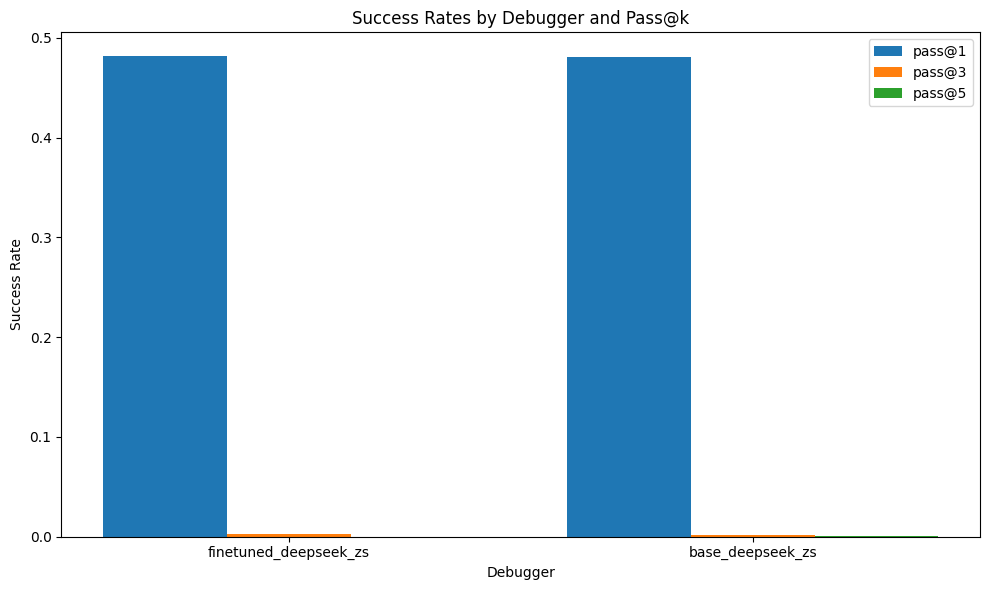

<Figure size 1000x600 with 0 Axes>

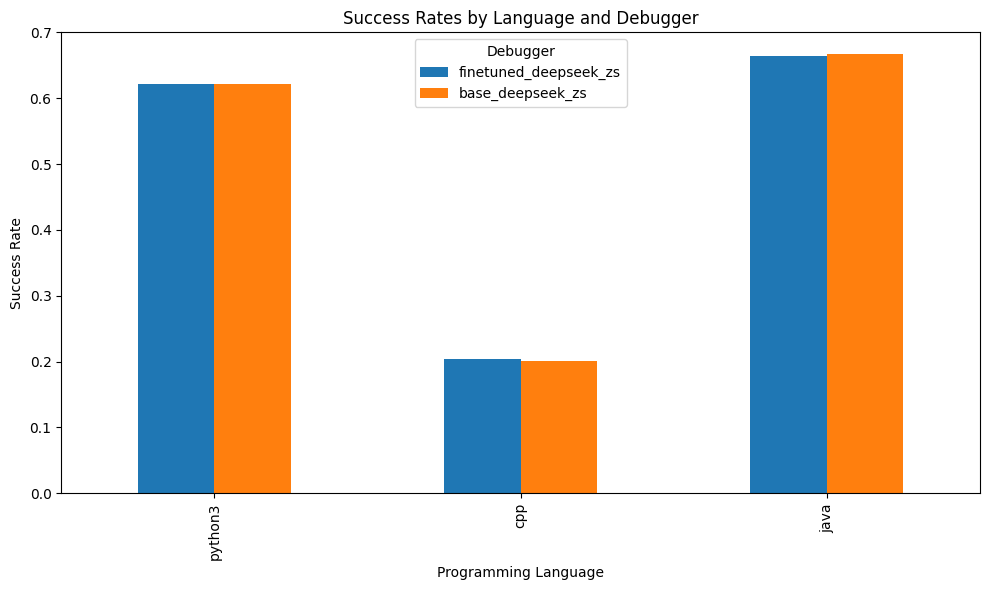

<Figure size 1200x800 with 0 Axes>

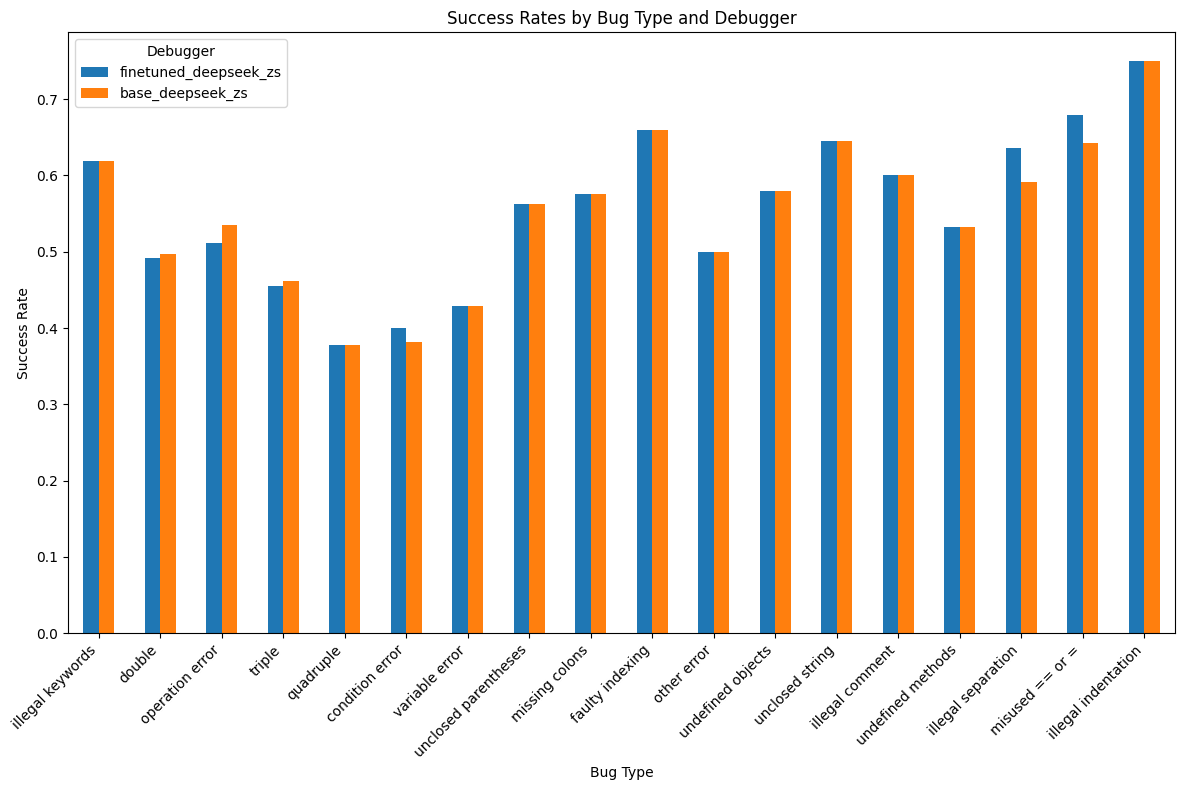

In [ ]:
# Run benchmarking on cached DebugBench samples
import os
import torch
import json
import time
import re
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize coordinator
coordinator = DebuggerCoordinator()

# 1. Enhanced code extraction parser
def add_improved_parser(coordinator):
    """Add an improved code extraction parser to the coordinator"""
    original_parser = coordinator.parse_code_from_output

    def improved_parser(full_output, buggy_code):
        try:
            extracted_code = original_parser(full_output, buggy_code)

            # If the extracted code still contains markdown or explanatory text
            if "```" in extracted_code or extracted_code.startswith("The ") or "Here's" in extracted_code:
                # Try to extract code blocks first
                for lang in ["python", "cpp", "java", ""]:
                    pattern = f"```{lang}(.*?)```" if lang else r"```(.*?)```"
                    code_blocks = re.findall(pattern, full_output, re.DOTALL)
                    if code_blocks:
                        return code_blocks[0].strip()

                # Language-specific extraction if code blocks aren't found
                if "def " in buggy_code:  # Python
                    function_match = re.search(r'(def\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\([^)]*\):.*?(?:return|pass).*?)(?:\n\n|$)', full_output, re.DOTALL)
                    if function_match:
                        return function_match.group(1).strip()
                elif "public class" in buggy_code:  # Java
                    class_match = re.search(r'(public\s+class\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\{.*\})', full_output, re.DOTALL)
                    if class_match:
                        return class_match.group(1).strip()
                elif "int " in buggy_code and "(" in buggy_code and ")" in buggy_code:  # C++
                    function_match = re.search(r'([a-zA-Z_][a-zA-Z0-9_]*\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\([^)]*\)\s*\{.*\})', full_output, re.DOTALL)
                    if function_match:
                        return function_match.group(1).strip()

                # Simple replacements for common bug fixes
                if "return 0" in buggy_code and "return 1" in full_output:
                    return buggy_code.replace("return 0", "return 1")
                if "if (nums[i] < maxVal)" in buggy_code and "if (nums[i] > maxVal)" in full_output:
                    return buggy_code.replace("if (nums[i] < maxVal)", "if (nums[i] > maxVal)")

            return extracted_code

        except Exception as e:
            print(f"Error in code extraction: {e}")
            return full_output.strip()

    coordinator.parse_code_from_output = improved_parser
    return coordinator

# Apply the improved parser
coordinator = add_improved_parser(coordinator)

# 2. Load debuggers
base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers"

debugger_configs = [
    {
        "name": "finetuned_deepseek_zs",
        "module": os.path.join(base_path, "zero_shot", "finetuned_deep_seek.py"),
        "class": "FinetunedDeepSeekDebugger",
        "is_error_enhanced": False,
        "description": "Fine-tuned DeepSeek Coder"
    },
    {
        "name": "base_deepseek_zs",
        "module": os.path.join(base_path, "zero_shot", "base_deep_seek.py"),
        "class": "BaseDeepSeekDebugger",
        "is_error_enhanced": False,
        "description": "Base DeepSeek Coder"
    }
]

# Clear GPU memory and load models
torch.cuda.empty_cache()
load_results = coordinator.load_all_debuggers(debugger_configs)
successful_debuggers = [name for name, success in load_results.items() if success]

print(f"Successfully loaded debuggers: {successful_debuggers}")

# 3. Load cached samples
def load_cached_samples(cache_file):
    """Load preprocessed samples from a cache file"""
    if not os.path.exists(cache_file):
        raise FileNotFoundError(f"Cache file not found: {cache_file}")

    with open(cache_file, 'r') as f:
        samples = json.load(f)

    print(f"Loaded {len(samples)} samples from cache")
    return samples

# Set path to cached samples
coordinator_base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing"
cache_dir = os.path.join(coordinator_base_path, "cached_samples")

# Find the most recent cache file
cache_files = [f for f in os.listdir(cache_dir) if f.startswith("debugbench_samples_") and f.endswith(".json")]
if not cache_files:
    raise FileNotFoundError("No cache files found. Run preprocessing first.")

most_recent_cache = sorted(cache_files)[-1]  #sort alphabetically
cache_file_path = os.path.join(cache_dir, most_recent_cache)
print(f"Using cache file: {cache_file_path}")

cached_samples = load_cached_samples(cache_file_path)

# 4. Run benchmark with pass@k
def run_benchmark_with_attempts(samples, num_samples=50, k_values=[1, 3, 5], attempts_per_sample=5):
    """
    Run benchmark on cached samples with pass@k metrics

    Args:
        samples: List of preprocessed samples
        num_samples: Maximum number of samples to test
        k_values: List of k values for pass@k metrics
        attempts_per_sample: Number of attempts for each sample

    Returns:
        Dictionary with benchmark results
    """
    # Limit to requested number of samples
    if num_samples < len(samples):
        samples = samples[:num_samples]

    # Initialize results dictionary with pass@k metrics
    results = {
        "metadata": {
            "timestamp": datetime.now().isoformat(),
            "num_samples": len(samples),
            "k_values": k_values,
            "cache_file": cache_file_path,
            "debuggers": {name: coordinator.debuggers[name]["description"] for name in successful_debuggers}
        },
        "debugger_results": {
            name: {
                "metrics": {
                    "total_samples": 0,
                    **{f"successful_fixes@{k}": 0 for k in k_values},
                    **{f"success_rate@{k}": 0.0 for k in k_values},
                    **{f"avg_time@{k}": 0.0 for k in k_values}
                },
                "sample_results": []
            } for name in successful_debuggers
        },
        "language_results": {},
        "bug_type_results": {}
    }

    print(f"Running benchmark on {len(samples)} samples with {len(successful_debuggers)} debuggers")

    # Process each sample
    for i, sample in enumerate(tqdm(samples, desc="Testing samples")):
        for debugger_name in successful_debuggers:
            attempts = []

            # Make multiple attempts for pass@k evaluation
            for _ in range(attempts_per_sample):
                # Test the debugger on this sample
                start_time = time.time()
                result = coordinator.test_debugger(
                    debugger_name=debugger_name,
                    task=sample["task"],
                    buggy_code=sample["buggy_code"],
                    test_cases=sample["test_cases"],
                    language=sample["language"]
                )
                result["time_taken"] = time.time() - start_time
                attempts.append(result)

                # Stop if successful (for efficiency)
                if result["success"]:
                    break

            # Record results for this sample
            results["debugger_results"][debugger_name]["sample_results"].append({
                "sample_id": i,
                "attempts": attempts,
                "language": sample["language"],
                "bug_type": sample["bug_type"],
                "category": sample["category"]
            })

            # Update metrics for this debugger
            metrics = results["debugger_results"][debugger_name]["metrics"]
            metrics["total_samples"] += 1

            # Update pass@k metrics
            for k in k_values:
                if k <= len(attempts) and any(attempt["success"] for attempt in attempts[:k]):
                    metrics[f"successful_fixes@{k}"] += 1

                    # Update timing statistics for successful attempts
                    success_idx = next((i for i, a in enumerate(attempts[:k]) if a["success"]), None)
                    if success_idx is not None:
                        success_time = attempts[success_idx]["time_taken"]
                        current_avg = metrics[f"avg_time@{k}"]
                        current_count = metrics[f"successful_fixes@{k}"]
                        metrics[f"avg_time@{k}"] = ((current_avg * (current_count - 1)) + success_time) / current_count

    # Calculate final success rates and aggregated statistics
    for debugger_name, debugger in results["debugger_results"].items():
        metrics = debugger["metrics"]
        total = metrics["total_samples"]

        # Calculate success rates
        for k in k_values:
            metrics[f"success_rate@{k}"] = metrics[f"successful_fixes@{k}"] / total if total > 0 else 0

        # Aggregate by language
        languages_data = {}
        for sample in debugger["sample_results"]:
            lang = sample["language"]
            if lang not in languages_data:
                languages_data[lang] = {"count": 0, "success": 0}

            languages_data[lang]["count"] += 1
            if any(attempt["success"] for attempt in sample["attempts"]):
                languages_data[lang]["success"] += 1

        # Calculate language-specific success rates
        for lang, data in languages_data.items():
            if lang not in results["language_results"]:
                results["language_results"][lang] = {}

            results["language_results"][lang][debugger_name] = {
                "count": data["count"],
                "success": data["success"],
                "success_rate": data["success"] / data["count"] if data["count"] > 0 else 0
            }

        # Aggregate by bug type
        bug_types_data = {}
        for sample in debugger["sample_results"]:
            bug_type = sample["bug_type"]
            if bug_type not in bug_types_data:
                bug_types_data[bug_type] = {"count": 0, "success": 0}

            bug_types_data[bug_type]["count"] += 1
            if any(attempt["success"] for attempt in sample["attempts"]):
                bug_types_data[bug_type]["success"] += 1

        # Calculate success rates by bug type
        for bug_type, data in bug_types_data.items():
            if bug_type not in results["bug_type_results"]:
                results["bug_type_results"][bug_type] = {}

            results["bug_type_results"][bug_type][debugger_name] = {
                "count": data["count"],
                "success": data["success"],
                "success_rate": data["success"] / data["count"] if data["count"] > 0 else 0
            }

    # Print summary of results
    print("\nBenchmark Results Summary:")
    for debugger_name, debugger in results["debugger_results"].items():
        print(f"\n{debugger_name}:")
        metrics = debugger["metrics"]
        for k in k_values:
            print(f"  pass@{k}: {metrics[f'success_rate@{k}']:.2%} ({metrics[f'successful_fixes@{k}']} / {metrics['total_samples']})")
            print(f"  avg_time@{k}: {metrics[f'avg_time@{k}']:.2f}s")

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = os.path.join(coordinator.results_dir, f"debugbench_results_{timestamp}.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to {results_file}")

    # Generate visualizations
    visualize_results(results, k_values)

    print("\nBug Type Performance Analysis:")

    # Calculate overall success rate by bug type
    bug_types = list(results["bug_type_results"].keys())
    for bug_type in bug_types:
        all_debuggers_count = sum(results["bug_type_results"][bug_type][debugger]["count"]
                                for debugger in results["debugger_results"].keys())
        all_debuggers_success = sum(results["bug_type_results"][bug_type][debugger]["success"]
                                  for debugger in results["debugger_results"].keys())
        overall_rate = all_debuggers_success / all_debuggers_count if all_debuggers_count > 0 else 0

        print(f"Bug type: {bug_type}")
        print(f"  Count: {all_debuggers_count}")
        print(f"  Overall success rate: {overall_rate:.2%}")

        # Compare debugger performance on this bug type
        print("  Debugger comparison:")
        for debugger in results["debugger_results"].keys():
            if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]:
                bug_data = results["bug_type_results"][bug_type][debugger]
                print(f"    {debugger}: {bug_data['success_rate']:.2%} ({bug_data['success']}/{bug_data['count']})")
        print()

    return results

# 5. Visualization functions
def visualize_results(results, k_values):
    """Generate visualizations for benchmark results"""
    # Prepare data for plotting
    debugger_names = list(results["debugger_results"].keys())

    # Plot 1: Pass@k success rates
    plt.figure(figsize=(10, 6))
    x = range(len(debugger_names))
    width = 0.8 / len(k_values)

    for i, k in enumerate(k_values):
        success_rates = [results["debugger_results"][name]["metrics"][f"success_rate@{k}"] for name in debugger_names]
        plt.bar([pos + i * width for pos in x], success_rates, width=width, label=f"pass@{k}")

    plt.xlabel("Debugger")
    plt.ylabel("Success Rate")
    plt.title("Success Rates by Debugger and Pass@k")
    plt.xticks([pos + (len(k_values) - 1) * width / 2 for pos in x], debugger_names)
    plt.legend()
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(coordinator.plots_dir, f"success_rates_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(plot_path)
    print(f"Success rates plot saved to {plot_path}")

    # Plot 2: Language-specific success rates
    languages = list(results["language_results"].keys())
    if languages:
        plt.figure(figsize=(10, 6))
        data = {
            debugger: [results["language_results"][lang][debugger]["success_rate"]
                      if lang in results["language_results"] and debugger in results["language_results"][lang]
                      else 0
                      for lang in languages]
            for debugger in debugger_names
        }

        df = pd.DataFrame(data, index=languages)
        ax = df.plot(kind="bar", figsize=(10, 6))
        plt.xlabel("Programming Language")
        plt.ylabel("Success Rate")
        plt.title("Success Rates by Language and Debugger")
        plt.legend(title="Debugger")
        plt.tight_layout()

        # Save plot
        lang_plot_path = os.path.join(coordinator.plots_dir, f"language_success_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(lang_plot_path)
        print(f"Language success plot saved to {lang_plot_path}")

    # Plot 3: Bug type success rates
    bug_types = list(results["bug_type_results"].keys())
    if len(bug_types) > 1:  # Only create if we have multiple bug types
        plt.figure(figsize=(12, 8))
        data = {
            debugger: [results["bug_type_results"][bug_type][debugger]["success_rate"]
                      if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]
                      else 0
                      for bug_type in bug_types]
            for debugger in debugger_names
        }

        df = pd.DataFrame(data, index=bug_types)
        ax = df.plot(kind="bar", figsize=(12, 8))
        plt.xlabel("Bug Type")
        plt.ylabel("Success Rate")
        plt.title("Success Rates by Bug Type and Debugger")
        plt.legend(title="Debugger")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        # Save plot
        bug_plot_path = os.path.join(coordinator.plots_dir, f"bug_type_success_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(bug_plot_path)
        print(f"Bug type success plot saved to {bug_plot_path}")

def analyze_bug_type_performance(results):
    print("\nBug Type Performance Analysis:")

    # Calculate overall success rate by bug type
    bug_types = list(results["bug_type_results"].keys())
    for bug_type in bug_types:
        all_debuggers_count = sum(results["bug_type_results"][bug_type][debugger]["count"]
                                for debugger in results["debugger_results"].keys())
        all_debuggers_success = sum(results["bug_type_results"][bug_type][debugger]["success"]
                                  for debugger in results["debugger_results"].keys())
        overall_rate = all_debuggers_success / all_debuggers_count if all_debuggers_count > 0 else 0

        print(f"Bug type: {bug_type}")
        print(f"  Count: {all_debuggers_count}")
        print(f"  Overall success rate: {overall_rate:.2%}")

        # Compare debugger performance on this bug type
        print("  Debugger comparison:")
        for debugger in results["debugger_results"].keys():
            if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]:
                bug_data = results["bug_type_results"][bug_type][debugger]
                print(f"    {debugger}: {bug_data['success_rate']:.2%} ({bug_data['success']}/{bug_data['count']})")
        print()

# 6. Run the benchmark
# Set parameters
num_samples = 999  # We can adjust
k_values = [1, 3, 5]  # pass@k values
attempts_per_sample = 5  # Number of attempts for each sample

# Run benchmark on cached samples
benchmark_results = run_benchmark_with_attempts(
    samples=cached_samples,
    num_samples=num_samples,
    k_values=k_values,
    attempts_per_sample=attempts_per_sample
)

print("Benchmarking complete!")

## Benchmarking Code Llama and StarCoder2 - not implemented due to lack of time

In [ ]:
# Run benchmarking on cached DebugBench samples
import os
import torch
import json
import time
import re
from datetime import datetime
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Initialize coordinator
coordinator = DebuggerCoordinator()

# 1. Enhanced code extraction parser
def add_improved_parser(coordinator):
    """Add an improved code extraction parser to the coordinator"""
    original_parser = coordinator.parse_code_from_output

    def improved_parser(full_output, buggy_code):
        try:
            extracted_code = original_parser(full_output, buggy_code)

            # If the extracted code still contains markdown or explanatory text
            if "```" in extracted_code or extracted_code.startswith("The ") or "Here's" in extracted_code:
                # Try to extract code blocks first
                for lang in ["python", "cpp", "java", ""]:
                    pattern = f"```{lang}(.*?)```" if lang else r"```(.*?)```"
                    code_blocks = re.findall(pattern, full_output, re.DOTALL)
                    if code_blocks:
                        return code_blocks[0].strip()

                # Language-specific extraction if code blocks aren't found
                if "def " in buggy_code:  # for Python
                    function_match = re.search(r'(def\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\([^)]*\):.*?(?:return|pass).*?)(?:\n\n|$)', full_output, re.DOTALL)
                    if function_match:
                        return function_match.group(1).strip()
                elif "public class" in buggy_code:  # for Java
                    class_match = re.search(r'(public\s+class\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\{.*\})', full_output, re.DOTALL)
                    if class_match:
                        return class_match.group(1).strip()
                elif "int " in buggy_code and "(" in buggy_code and ")" in buggy_code:  # for C++
                    function_match = re.search(r'([a-zA-Z_][a-zA-Z0-9_]*\s+[a-zA-Z_][a-zA-Z0-9_]*\s*\([^)]*\)\s*\{.*\})', full_output, re.DOTALL)
                    if function_match:
                        return function_match.group(1).strip()

                # Simple replacements for common bug fixes
                if "return 0" in buggy_code and "return 1" in full_output:
                    return buggy_code.replace("return 0", "return 1")
                if "if (nums[i] < maxVal)" in buggy_code and "if (nums[i] > maxVal)" in full_output:
                    return buggy_code.replace("if (nums[i] < maxVal)", "if (nums[i] > maxVal)")

            return extracted_code

        except Exception as e:
            print(f"Error in code extraction: {e}")
            return full_output.strip()

    coordinator.parse_code_from_output = improved_parser
    return coordinator

# Apply the improved parser
coordinator = add_improved_parser(coordinator)

# 2. Load debuggers
base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers"

debugger_configs = [
    {
        "name": "CodeLlama_7B_zs",
        "module": os.path.join(base_path, "zero_shot", "codellama.py"),
        "class": "CodeLlamaDebugger",
        "is_error_enhanced": False,
        "description": "CodeLlama 7B Instruct"
    },
    {
        "name": "StarCoder2_7B_zs",
        "module": os.path.join(base_path, "zero_shot", "starcoder2.py"),
        "class": "StarCoderDebugger",
        "is_error_enhanced": False,
        "description": "StarCoder 2 7B"
    }

]

# Clear GPU memory and load models
torch.cuda.empty_cache()
load_results = coordinator.load_all_debuggers(debugger_configs)
successful_debuggers = [name for name, success in load_results.items() if success]

print(f"Successfully loaded debuggers: {successful_debuggers}")

# 3. Load cached samples
def load_cached_samples(cache_file):
    """Load preprocessed samples from a cache file"""
    if not os.path.exists(cache_file):
        raise FileNotFoundError(f"Cache file not found: {cache_file}")

    with open(cache_file, 'r') as f:
        samples = json.load(f)

    print(f"Loaded {len(samples)} samples from cache")
    return samples

# Set path to cached samples
coordinator_base_path = "/content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing"
cache_dir = os.path.join(coordinator_base_path, "cached_samples")

# Find the most recent cache file
cache_files = [f for f in os.listdir(cache_dir) if f.startswith("debugbench_samples_") and f.endswith(".json")]
if not cache_files:
    raise FileNotFoundError("No cache files found. Run preprocessing first.")

most_recent_cache = sorted(cache_files)[-1]  #sort alphabetically
cache_file_path = os.path.join(cache_dir, most_recent_cache)
print(f"Using cache file: {cache_file_path}")

cached_samples = load_cached_samples(cache_file_path)

# 4. Run benchmark with pass@k
def run_benchmark_with_attempts(samples, num_samples=50, k_values=[1, 3, 5], attempts_per_sample=5, checkpoint_interval=10):
    """
    Run benchmark on cached samples with pass@k metrics

    Args:
        samples: List of preprocessed samples
        num_samples: Maximum number of samples to test
        k_values: List of k values for pass@k metrics
        attempts_per_sample: Number of attempts for each sample

    Returns:
        Dictionary with benchmark results
    """
    # Limit to requested number of samples
    if num_samples < len(samples):
        samples = samples[:num_samples]

    # Initialize results dictionary with pass@k metrics
    results = {
        "metadata": {
            "timestamp": datetime.now().isoformat(),
            "num_samples": len(samples),
            "k_values": k_values,
            "cache_file": cache_file_path,
            "debuggers": {name: coordinator.debuggers[name]["description"] for name in successful_debuggers}
        },
        "debugger_results": {
            name: {
                "metrics": {
                    "total_samples": 0,
                    **{f"successful_fixes@{k}": 0 for k in k_values},
                    **{f"success_rate@{k}": 0.0 for k in k_values},
                    **{f"avg_time@{k}": 0.0 for k in k_values}
                },
                "sample_results": []
            } for name in successful_debuggers
        },
        "language_results": {},
        "bug_type_results": {}
    }

    print(f"Running benchmark on {len(samples)} samples with {len(successful_debuggers)} debuggers")

    # Process each sample
    for i, sample in enumerate(tqdm(samples, desc="Testing samples")):
        for debugger_name in successful_debuggers:
            attempts = []

            # Make multiple attempts for pass@k evaluation
            for _ in range(attempts_per_sample):
                # Test the debugger on this sample
                start_time = time.time()
                result = coordinator.test_debugger(
                    debugger_name=debugger_name,
                    task=sample["task"],
                    buggy_code=sample["buggy_code"],
                    test_cases=sample["test_cases"],
                    language=sample["language"]
                )
                result["time_taken"] = time.time() - start_time
                attempts.append(result)

                # Stop if successful (for efficiency)
                if result["success"]:
                    break

            # Record results for this sample
            results["debugger_results"][debugger_name]["sample_results"].append({
                "sample_id": i,
                "attempts": attempts,
                "language": sample["language"],
                "bug_type": sample["bug_type"],
                "category": sample["category"]
            })

            # Update metrics for this debugger
            metrics = results["debugger_results"][debugger_name]["metrics"]
            metrics["total_samples"] += 1

            # Update pass@k metrics
            for k in k_values:
                if k <= len(attempts) and any(attempt["success"] for attempt in attempts[:k]):
                    metrics[f"successful_fixes@{k}"] += 1

                    # Update timing statistics for successful attempts
                    success_idx = next((i for i, a in enumerate(attempts[:k]) if a["success"]), None)
                    if success_idx is not None:
                        success_time = attempts[success_idx]["time_taken"]
                        current_avg = metrics[f"avg_time@{k}"]
                        current_count = metrics[f"successful_fixes@{k}"]
                        metrics[f"avg_time@{k}"] = ((current_avg * (current_count - 1)) + success_time) / current_count

        # Save checkpoint every checkpoint_interval samples
        if (i+1) % checkpoint_interval == 0:
            checkpoint_timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
            checkpoint_file = os.path.join(coordinator.results_dir, f"checkpoint_results_sample{i+1}_{checkpoint_timestamp}.json")

            print(f"\nSaving checkpoint after {i+1}/{len(samples)} samples...")
            with open(checkpoint_file, 'w') as f:
                json.dump(results, f, indent=2)
            print(f"Checkpoint saved to {checkpoint_file}")

    # Calculate final success rates and aggregated statistics
    for debugger_name, debugger in results["debugger_results"].items():
        metrics = debugger["metrics"]
        total = metrics["total_samples"]

        # Calculate success rates
        for k in k_values:
            metrics[f"success_rate@{k}"] = metrics[f"successful_fixes@{k}"] / total if total > 0 else 0

        # Aggregate by language
        languages_data = {}
        for sample in debugger["sample_results"]:
            lang = sample["language"]
            if lang not in languages_data:
                languages_data[lang] = {"count": 0, "success": 0}

            languages_data[lang]["count"] += 1
            if any(attempt["success"] for attempt in sample["attempts"]):
                languages_data[lang]["success"] += 1

        # Calculate language-specific success rates
        for lang, data in languages_data.items():
            if lang not in results["language_results"]:
                results["language_results"][lang] = {}

            results["language_results"][lang][debugger_name] = {
                "count": data["count"],
                "success": data["success"],
                "success_rate": data["success"] / data["count"] if data["count"] > 0 else 0
            }

        # Aggregate by bug type
        bug_types_data = {}
        for sample in debugger["sample_results"]:
            bug_type = sample["bug_type"]
            if bug_type not in bug_types_data:
                bug_types_data[bug_type] = {"count": 0, "success": 0}

            bug_types_data[bug_type]["count"] += 1
            if any(attempt["success"] for attempt in sample["attempts"]):
                bug_types_data[bug_type]["success"] += 1

        # Calculate success rates by bug type
        for bug_type, data in bug_types_data.items():
            if bug_type not in results["bug_type_results"]:
                results["bug_type_results"][bug_type] = {}

            results["bug_type_results"][bug_type][debugger_name] = {
                "count": data["count"],
                "success": data["success"],
                "success_rate": data["success"] / data["count"] if data["count"] > 0 else 0
            }

    # Print summary of results
    print("\nBenchmark Results Summary:")
    for debugger_name, debugger in results["debugger_results"].items():
        print(f"\n{debugger_name}:")
        metrics = debugger["metrics"]
        for k in k_values:
            print(f"  pass@{k}: {metrics[f'success_rate@{k}']:.2%} ({metrics[f'successful_fixes@{k}']} / {metrics['total_samples']})")
            print(f"  avg_time@{k}: {metrics[f'avg_time@{k}']:.2f}s")

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    results_file = os.path.join(coordinator.results_dir, f"debugbench_results_{timestamp}.json")
    with open(results_file, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"\nResults saved to {results_file}")

    # Generate visualizations
    visualize_results(results, k_values)

    print("\nBug Type Performance Analysis:")

    # Calculate overall success rate by bug type
    bug_types = list(results["bug_type_results"].keys())
    for bug_type in bug_types:
        all_debuggers_count = sum(results["bug_type_results"][bug_type][debugger]["count"]
                                for debugger in results["debugger_results"].keys())
        all_debuggers_success = sum(results["bug_type_results"][bug_type][debugger]["success"]
                                  for debugger in results["debugger_results"].keys())
        overall_rate = all_debuggers_success / all_debuggers_count if all_debuggers_count > 0 else 0

        print(f"Bug type: {bug_type}")
        print(f"  Count: {all_debuggers_count}")
        print(f"  Overall success rate: {overall_rate:.2%}")

        # Compare debugger performance on this bug type
        print("  Debugger comparison:")
        for debugger in results["debugger_results"].keys():
            if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]:
                bug_data = results["bug_type_results"][bug_type][debugger]
                print(f"    {debugger}: {bug_data['success_rate']:.2%} ({bug_data['success']}/{bug_data['count']})")
        print()

    return results

# 5. Visualization functions
def visualize_results(results, k_values):
    """Generate visualizations for benchmark results"""
    # Prepare data for plotting
    debugger_names = list(results["debugger_results"].keys())

    # Plot 1: Pass@k success rates
    plt.figure(figsize=(10, 6))
    x = range(len(debugger_names))
    width = 0.8 / len(k_values)

    for i, k in enumerate(k_values):
        success_rates = [results["debugger_results"][name]["metrics"][f"success_rate@{k}"] for name in debugger_names]
        plt.bar([pos + i * width for pos in x], success_rates, width=width, label=f"pass@{k}")

    plt.xlabel("Debugger")
    plt.ylabel("Success Rate")
    plt.title("Success Rates by Debugger and Pass@k")
    plt.xticks([pos + (len(k_values) - 1) * width / 2 for pos in x], debugger_names)
    plt.legend()
    plt.tight_layout()

    # Save plot
    plot_path = os.path.join(coordinator.plots_dir, f"success_rates_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
    plt.savefig(plot_path)
    print(f"Success rates plot saved to {plot_path}")

    # Plot 2: Language-specific success rates
    languages = list(results["language_results"].keys())
    if languages:
        plt.figure(figsize=(10, 6))
        data = {
            debugger: [results["language_results"][lang][debugger]["success_rate"]
                      if lang in results["language_results"] and debugger in results["language_results"][lang]
                      else 0
                      for lang in languages]
            for debugger in debugger_names
        }

        df = pd.DataFrame(data, index=languages)
        ax = df.plot(kind="bar", figsize=(10, 6))
        plt.xlabel("Programming Language")
        plt.ylabel("Success Rate")
        plt.title("Success Rates by Language and Debugger")
        plt.legend(title="Debugger")
        plt.tight_layout()

        # Save plot
        lang_plot_path = os.path.join(coordinator.plots_dir, f"language_success_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(lang_plot_path)
        print(f"Language success plot saved to {lang_plot_path}")

    # Plot 3: Bug type success rates
    bug_types = list(results["bug_type_results"].keys())
    if len(bug_types) > 1:
        plt.figure(figsize=(12, 8))
        data = {
            debugger: [results["bug_type_results"][bug_type][debugger]["success_rate"]
                      if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]
                      else 0
                      for bug_type in bug_types]
            for debugger in debugger_names
        }

        df = pd.DataFrame(data, index=bug_types)
        ax = df.plot(kind="bar", figsize=(12, 8))
        plt.xlabel("Bug Type")
        plt.ylabel("Success Rate")
        plt.title("Success Rates by Bug Type and Debugger")
        plt.legend(title="Debugger")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()

        # Save plot
        bug_plot_path = os.path.join(coordinator.plots_dir, f"bug_type_success_{datetime.now().strftime('%Y%m%d_%H%M%S')}.png")
        plt.savefig(bug_plot_path)
        print(f"Bug type success plot saved to {bug_plot_path}")

def analyze_bug_type_performance(results):
    print("\nBug Type Performance Analysis:")

    # Calculate overall success rate by bug type
    bug_types = list(results["bug_type_results"].keys())
    for bug_type in bug_types:
        all_debuggers_count = sum(results["bug_type_results"][bug_type][debugger]["count"]
                                for debugger in results["debugger_results"].keys())
        all_debuggers_success = sum(results["bug_type_results"][bug_type][debugger]["success"]
                                  for debugger in results["debugger_results"].keys())
        overall_rate = all_debuggers_success / all_debuggers_count if all_debuggers_count > 0 else 0

        print(f"Bug type: {bug_type}")
        print(f"  Count: {all_debuggers_count}")
        print(f"  Overall success rate: {overall_rate:.2%}")

        # Compare debugger performance on this bug type
        print("  Debugger comparison:")
        for debugger in results["debugger_results"].keys():
            if bug_type in results["bug_type_results"] and debugger in results["bug_type_results"][bug_type]:
                bug_data = results["bug_type_results"][bug_type][debugger]
                print(f"    {debugger}: {bug_data['success_rate']:.2%} ({bug_data['success']}/{bug_data['count']})")
        print()

# 6. Run the benchmark
# Set parameters
num_samples = 999  # We can adjust
k_values = [1, 3, 5]  # pass@k values
attempts_per_sample = 5  # Number of attempts for each sample

# Run benchmark on cached samples
benchmark_results = run_benchmark_with_attempts(
    samples=cached_samples,
    num_samples=num_samples,
    k_values=k_values,
    attempts_per_sample=attempts_per_sample,
    checkpoint_interval=50
)

print("Benchmarking complete!")

DebuggerCoordinator initialized with base path: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder
Loading debugger 'finetuned_deepseek_zs' from /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers/zero_shot/finetuned_deep_seek.py
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Checking adapter path: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/training/finetuned/deepseek_coder_finetuned/final_finetuned_model
Files in adapter directory:
- trainer_state.json
- trainer_log_history.json
- README.md
- adapter_model.safetensors
- adapter_config.json
- tokenizer_config.json
- special_tokens_map.json
- tokenizer.json
Loading base model: deepseek-ai/deepseek-coder-6.7b-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loading fine-tuned adapter from: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/training/finetuned/deepseek_coder_finetuned/final_finetuned_model
Successfully loaded adapter!
Fine-tuned model loaded successfully!
Successfully loaded debugger: finetuned_deepseek_zs
Loading debugger 'base_deepseek_zs' from /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/debuggers/zero_shot/base_deep_seek.py
Using device: cuda
Loading model: deepseek-ai/deepseek-coder-6.7b-instruct


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Base model loaded successfully!
Successfully loaded debugger: base_deepseek_zs

Loaded 2/2 debuggers successfully
Successfully loaded debuggers: ['finetuned_deepseek_zs', 'base_deepseek_zs']
Using cache file: /content/drive/MyDrive/Academic_Professional_Planning/SPRING2025/GEN_AI/Multi_Agent_Self_Debugger_Coder/testing/cached_samples/debugbench_samples_20250517_234114.json
Loaded 999 samples from cache
Running benchmark on 999 samples with 2 debuggers


Testing samples:   0%|          | 0/999 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.

    LRUCache(int capacity) {
        size = capacity; 
        head->next = tail;
        tail->prev = head;  
    }

    void addNode(node* newNode) {
        node* temp = head->next;
        newNode->next = temp;
        newNode->prev = head;
        head->next = newNode;
        temp->prev = newNode;
    }

    void deleteNode(node* delNode) {
        node* delprev = delNode->prev;
        node* delnext = delNode->next;
        delprev->next = delnext;
        delnext->prev = delprev;
    }
    
    int get(int _key) {
        if (mpp.count(_key)) {
            node* nde = mpp[_key];
            int curr = nde->val;
            mpp.erase(_key);
            deleteNode(nde);
            addNode(nde);
            mpp[_key] = head->next;
            return curr;
        }
        return -1;
    }
};

int main() {
    Solution sol;
    LRUCache lRUCache(2); assert(lRUCache.put(1, 1) == nullptr); assert(lRUCache.put(2, 2) == nullptr); as